<a href="https://colab.research.google.com/github/antoinexp/Ph.D/blob/master/Neural_Net_Gaussian_Multibath.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package imports and standard definitions

In [2]:
#@title 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.display import clear_output
import tensorflow as tf
import itertools
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
print(tf.test.gpu_device_name())
tf.device('/device:GPU:0')

/device:GPU:0


Initializers definition

In [0]:
class Initializer:
  class normal:
    def __call__(self, shape): return tf.random.normal(shape)

  class spherical:
    def __call__(self, shape):
      X = tf.random.normal(shape)
      return tf.math.l2_normalize(X, axis=1)

Model Class

# Model
This section contains the code to implement the $(d \times N + N \times 1)$-parameters neural network to fit a function $f$ with:

\begin{equation}
    \hat f_\Theta : x \in \mathbb R^{d} \mapsto \sum_{i=1}^N a_i \sigma\left( \frac{x^T \theta_i}{\sqrt d} \right)
\end{equation}

For instance, we could have $\sigma(x,b) = \text{Relu} (x\cdot b)$. We define the training risk:
\begin{equation}
    R(X, \Theta) = \frac{1}{n} \sum_{i=1}^n (f(X_i) - \hat f_\Theta(X_i))^2 
\end{equation}

We will consider a random target functions from the class $\{f_\beta | \beta \in \mathcal S^d(\sqrt d) \}$ where:
\begin{equation}
  f_{\beta_0}(x) = x^T \beta_0
\end{equation}

We have the following process

\begin{equation}
\mathrm d a_i(t) = - \frac{1}{\lambda_a} \partial_{a_i} R(X, \Theta_t) \mathrm dt + \sqrt \frac{2}{\lambda_a \beta_a} \mathrm  dW^a_t
\end{equation}

\begin{equation}
\mathrm d \theta_i(t) = - \frac{1}{\lambda_\theta} \nabla_{\theta_i} R(X, \Theta_t) \mathrm dt + \sqrt \frac{2}{\lambda_\theta \beta_\theta} \mathrm  dW^\theta_t
\end{equation}

In [0]:
class Model(tf.Module):
  def __init__(self, N, n, d, n_test=None, 
               _lambda_a=1., 
               _lambda_theta=1., 
               _lambda_reg=0.1,
               _beta_a=1., 
               _beta_theta=1., 
               initializer=Initializer.spherical(), 
               activation="linear"):
    self._lambda_a = _lambda_a
    self._lambda_theta = _lambda_theta
    self._beta_a = _beta_a
    self._beta_theta = _beta_theta
    self.initializer = initializer
    self.activation = tf.keras.layers.Activation(activation).activation
    self._lambda_reg = _lambda_reg

    self._N = N
    self._n = n
    self._d = d

    self._a = tf.Variable(self.initializer((1,self._N))[0])
    self._theta = tf.Variable((d**0.5)*self.initializer((self._N,d)))

    self._beta0 = self.initializer((1,d))[0]
    self.X_train = (d**0.5)*self.initializer((n,d))
    self.Y_train = tf.tensordot(self.X_train, self._beta0, 1)

    self._n_test = n_test
    if not n_test: self._n_test = n
    self.X_test = (d**0.5)*self.initializer((n_test,d))
    self.Y_test = tf.tensordot(self.X_test, self._beta0, 1)


  @tf.function
  def __call__(self, X):
    d = X.shape[1]
    W = tf.tensordot(X, tf.transpose(self._theta), 1) / d
    Z = (d**0.5)*self.activation(W)
    return tf.tensordot(Z, self._a, 1)

  @tf.function
  def R(self, X, Y, n=None):
    error = Y - self(X)
    if not n: n = self._n
    reg = (self._N/self._d)*self._lambda_reg*(tf.norm(self._a)**2.)
    return (1./n)*tf.norm(error)**2. + reg

  def R_train(self):
    return self.R(self.X_train, self.Y_train, n=self._n)

  def R_test(self):
    return self.R(self.X_test, self.Y_test, n=self._n_test)


  @tf.function
  def gradient_a(self):
    R = self.R(self.X_train, self.Y_train)
    grad_a = tf.gradients(R, self._a)[0]
    return grad_a

  @tf.function
  def learn(self, dt=0.1):
    R = self.R(self.X_train, self.Y_train)
    grad_a = tf.gradients(R, self._a)[0]
    grad_theta = tf.gradients(R, self._theta)[0]

    dW_a = tf.random.normal((self._N,))
    dW_theta = tf.random.normal((self._N,self._d))

    d_a = ((-1./self._lambda_a)*grad_a*dt + 
      ((2./(self._lambda_a*self._beta_a))**0.5)*(dt**0.5)*dW_a)
    d_theta = ((-1./self._lambda_theta)*grad_theta*dt + 
        ((2./(self._lambda_theta*self._beta_theta))**0.5)*(dt**0.5)*dW_theta)

    self._a.assign_add(d_a)
    self._theta.assign_add(d_theta)

    return self.R_train()

  @tf.function
  def learn_steps(self, dt=0.1, steps=10):
    res = 0.
    for _ in tf.range(steps):
      res = self.learn(dt)
    return res

  def learn_epochs(self, dt=0.1, steps=10, epochs=10, callback=None):
    history = dict(epoch=[], step=[], train_mse=[], test_mse=[])
    for epoch in range(epochs):
      history["epoch"].append(epoch)
      history["step"].append(epoch*steps)
      if epoch==0:
        history["train_mse"].append(model.R_train().numpy())
      else:
        history["train_mse"].append(model.learn_steps(dt, steps).numpy())
      history["test_mse"].append(model.R_test().numpy())
      if callback:
        callback(history)
    return history

  @tf.function
  def set_a_from_least_square_estimator(self, _lambda=0.01):
    W = tf.tensordot(self.X_train, tf.transpose(self._theta), 1) / (self._d**0.5)
    W = self.activation(W)
    Z = tf.tensordot(tf.transpose(W), W, 1)
    Z = tf.linalg.pinv(Z + (_lambda*self._N/self._d)*tf.eye(self._N))
    Z = tf.tensordot(Z, tf.transpose(W), 1)
    Z = tf.tensordot(Z, self.Y_train, 1)
    self._a.assign(Z)
    return self.R_train()


In [0]:
def plot_history(history, legend=True):
    plt.plot(history["step"], history["train_mse"], label="train mse")
    plt.plot(history["step"], history["test_mse"], label="test mse")
    plt.xlabel("step")
    plt.ylim((0., None))
    plt.grid(True)
    if legend:
      plt.legend()

# Example

In [0]:
#@title Model Config { run: "auto" }
config=dict(
    activation = "relu" #@param ["linear", "relu", "tanh", "sigmoid"]
    ,
    _lambda_a=1. #@param {type:"number"}
    , 
    _lambda_theta=1e10 #@param {type:"number"}
    ,
    _beta_a=1e10 #@param {type:"number"}
    ,
    _beta_theta=1e10 #@param {type:"number"}
    , 
    _lambda_reg=0. #@param {type:"number"}
    ,

    N=140 #@param {type:"slider", min:0, max:400, step:1}
    ,
    n=140 #@param {type:"slider", min:0, max:400, step:1}
    , 
    d=66 #@param {type:"slider", min:0, max:400, step:1}
    ,
    n_test=100 #@param {type:"slider", min:0, max:400, step:1}
       
)

runtime_parameters=dict(
    dt=0.01 #@param {type:"number"}
    ,
    steps=10 #@param {type:"number"}
    ,
    epochs=1000 #@param {type:"number"}
)



,activation,_lambda_a,_lambda_theta,_beta_a,_beta_theta,_lambda_reg,N,n,d,n_test
0,relu,1.0,1.000000e+10,1.000000e+10,1.000000e+10,0.0,140,140,66,100


final test error: 1.0831217


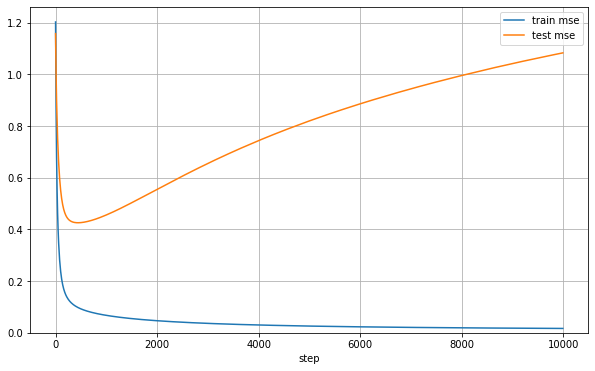

In [35]:
#@title Run Gradient Descent
model = Model(**config)

history = model.learn_epochs(**runtime_parameters)

plt.figure(figsize=(10,6))
plot_history(history)
plt.plot()


display(pd.DataFrame([list(config.values())], columns=list(config)))
print("final test error:", model.R_test().numpy())


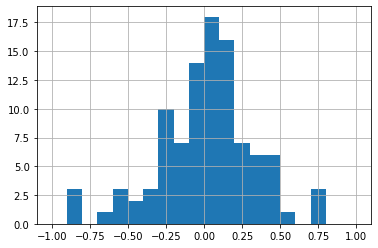

In [0]:
#@title "a" distribution
plt.hist(model._a.numpy(), bins=20, range=(-1,1))
plt.grid()

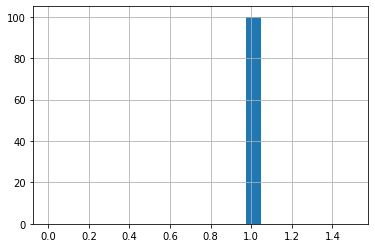

In [0]:
#@title ||theta|| distribution
data = tf.norm(model._theta/(model._d**0.5), axis=1).numpy()
plt.hist(data, bins=20, range=(0, 1.5))
plt.grid()

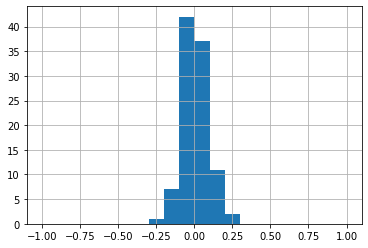

In [0]:
#@title <theta_i, beta0> distribution
data = tf.tensordot(model._theta/(model._d**0.5), model._beta0, 1).numpy()
plt.hist(data, bins=20, range=(-1.,1.))
plt.grid(True)

In [0]:
#@title cosine distance between 'average beta' and beta0
avg_beta = tf.tensordot(tf.transpose(model._theta), model._a, 1)/(model._d**0.5)
data = tf.tensordot(model._beta0/tf.norm(model._beta0), avg_beta/tf.norm(avg_beta), 1)
print(data.numpy())

0.3206056


In [0]:
l = []
for _ in range(50):
  model = Model(**config)
  model.set_a_from_least_square_estimator(1e-6)
  l.append(dict(
      train_mse=model.R_train().numpy(),
      test_mse=model.R_test().numpy()
  ))
df = pd.DataFrame(l)

In [0]:
df.describe()

,train_mse,test_mse
count,50.000000,50.000000
mean,0.010444,3.758690
std,0.009055,2.015198
min,0.000663,1.197066
25%,0.004001,2.527775
50%,0.007510,3.243391
75%,0.013425,4.337146
max,0.041037,12.210058


# MSE Horizon

In [0]:
#@title Base Config { run: "auto" }
config=dict(
    activation = "relu" #@param ["linear", "relu", "tanh", "sigmoid"]
    ,
    _lambda_a=1. #@param {type:"number"}
    , 
    _lambda_theta=1e10 #@param {type:"number"}
    ,
    _beta_a=1e10 #@param {type:"number"}
    ,
    _beta_theta=1e10 #@param {type:"number"}
    , 
    _lambda_reg=0. #@param {type:"number"}
    ,
    n=150 #@param {type:"slider", min:0, max:400, step:1}
    , 
    d=50 #@param {type:"slider", min:0, max:400, step:1}
    ,
    n_test=100 #@param {type:"slider", min:0, max:400, step:1}
       
)

runtime_parameters=dict(
    dt=0.01 #@param {type:"number"}
    ,
    steps=30000 #@param {type:"number"}
    ,
    epochs=2
)


In [0]:
N_n_range = np.linspace(0.1, 2., 15)
N_samples = 5

In [46]:
l = []
for i,N_n in itertools.product(range(N_samples), N_n_range):
  print(i, N_n)
  config["N"] = int(config["n"]*N_n)

  model = Model(**config)
  history = model.learn_epochs(**runtime_parameters)

  l.append(
      dict(
          i=i,
          test_mse=history["test_mse"][-1],
          train_mse=history["train_mse"][-1],
          **config
      )
  )
clear_output()
print("done")

done


In [0]:
df = pd.DataFrame(l)
df["N_n"] = df["N"]/df["n"]

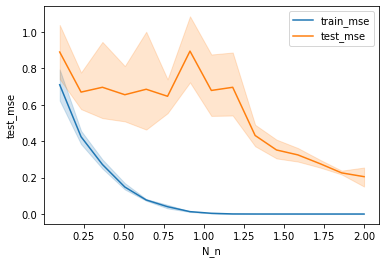

In [48]:
sns.lineplot(x="N_n", y="train_mse", data=df, label="train_mse")
sns.lineplot(x="N_n", y="test_mse", data=df, label="test_mse")

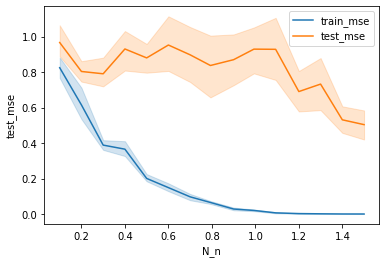

In [0]:
sns.lineplot(x="N_n", y="train_mse", data=df, label="train_mse")
sns.lineplot(x="N_n", y="test_mse", data=df, label="test_mse")